In [2]:
import pandas as pd

# Load the data to see its structure again
file_path = 'diego_data.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()


,ZTFID,IAUID,discdate,RA,Dec,peakt,peakfilt,peakmag,peakabs,duration,rise,fade,type,redshift,hostabs,hostcol,b,A_V
0,ZTF17aabtvsy,SN2022yei,2022-10-20 11:24:40.608,10:35:32.09,+37:38:59.0,1870.99,r,18.0303,-19.41,>34.229,>6.01,28.219,SN Ia,0.06922,-22.70,1.06,59.641962,0.053
1,ZTF17aabvong,SN2024xxq,2024-10-13 07:51:49.824,02:05:07.68,+11:14:55.1,2606.75,g,16.8039,-19.57,23.222,8.464,14.758,SN Ia,0.03400,-21.57,0.87,-47.664064,0.446
2,ZTF17aacldgo,SN2022zxv,2022-11-10 09:38:52.800,03:09:24.35,-04:53:39.2,1897.75,g,18.7979,-18.91,>8.87,>3.85,>5.02,SN Ia,0.07200,-20.57,0.99,-50.332472,0.183
3,ZTF17aadlxmv,SN2020adv,2020-01-15 08:26:07.000,08:29:47.59,+33:54:22.8,879.69,g,17.9475,-19.34,25.146,10.951,14.195,SN Ia,0.06200,-22.17,0.92,34.174702,0.106
4,ZTF18aaaonon,SN2022jjs,2022-04-30 04:42:14.400,10:19:05.51,+14:24:16.6,1703.77,g,18.5663,-19.08,>18.631,3.691,>14.94,SN Ia,0.07141,-21.67,1.10,52.363911,0.150


In [5]:
import os
import numpy as np
import urllib.request
from astropy.coordinates import SkyCoord
from astropy.utils.data import download_file
import astropy.units as u

def ztf_cone_search(pos):
    """
    Query the ZTF database for observations near a given position.
    
    Parameters:
    pos (SkyCoord): The position to query (RA, Dec).

    Returns:
    np.ndarray: Structured array of observation results.
    """
    # Build the URL for the ZTF database query
    url = f"https://irsa.ipac.caltech.edu/ibe/search/ztf/products/sci?POS={pos.ra.deg},{pos.dec.deg}"
    fname = download_file(url, timeout=300, cache=True)

    lines = []
    with open(fname, 'r') as fp:
        for line in fp:
            if line[0] == "\\":
                # Skip comment lines
                continue
            lines.append(line)
    
    # Parse column names and their positions
    colnames = [col.strip() for col in lines[0].strip()[1:-1].split('|')]
    colmarkers = [0]
    ind = 0
    while ind != -1:
        ind = lines[0].find('|', ind + 1)
        if ind != -1:
            colmarkers.append(ind)

    # Define data types for each field
    ctypes = {'int': int, 'long': int, 'float': float, 'double': float, 'char': "U24"}
    ctypes2 = ctypes.copy()
    ctypes2["char"] = str
    coltypes = [ctypes[ctype.strip()] for ctype in lines[1].strip()[1:-1].split('|')]
    coltypes2 = [ctypes2[ctype.strip()] for ctype in lines[1].strip()[1:-1].split('|')]
    dtype = [(colname, coltype) for colname, coltype in zip(colnames, coltypes)]

    # Parse data rows
    rows = []
    for index, line in enumerate(lines):
        if index < 4:
            # Skip header rows
            continue

        row = [coltypes2[icol](line[colmarkers[icol] + 1:colmarkers[icol + 1]].strip()) 
               for icol in range(len(colnames))]
        rows.append(np.array(tuple(row), dtype=dtype))
    return np.array(rows)

#def download_ztf_sci(rows, suffix='sciimg', clobber=False, allquadrants=False):
    """
    Download ZTF science images for specified rows.

    Parameters:
    rows (np.ndarray): Structured array of observation results.
    suffix (str): Image suffix to download (default: 'sciimg').
    clobber (bool): Overwrite existing files (default: False).
    allquadrants (bool): Download all quadrants (default: False).
    """
    baseurl = 'https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/'
    basedir = '/home/jovyan/research/ZTF_images/'
    
    for row in rows:
        filefracday = str(row['filefracday'])
        yyyy = filefracday[:4]
        mmdd = filefracday[4:8]
        fracday = filefracday[8:]
        paddedfield = f"{row['field']:06d}"
        paddedccdid = f"{row['ccdid']:02d}"
        
        # Ensure local directories exist
        dirname = basedir
        for subdir in [yyyy, mmdd, fracday]:
            dirname = os.path.join(dirname, subdir)
            if not os.path.exists(dirname):
                os.mkdir(dirname)
        
        # Determine quadrants
        qids = np.arange(1, 5) if allquadrants else [row['qid']]

        for qid in qids:
            # Build local file name
            fname = f"ztf_{filefracday}_{paddedfield}_{row['filtercode']}"
            fname += f"_c{paddedccdid}_{row['imgtypecode']}_q{qid}_{suffix}.fits"
            filename = os.path.join(basedir, yyyy, mmdd, fracday, fname)

            if os.path.exists(filename) and not clobber:
                continue

            # Download the file
            url = f"{baseurl}/{yyyy}/{mmdd}/{fracday}/{fname}"
            print("Downloading", url)
            urllib.request.urlretrieve(url, filename)


In [9]:
ztf_cone_search(SkyCoord("10:35:32.09 +37:38:59.0", unit="hour,deg"))

array([(1, 158.88370833, 37.64972222, 158.95510588, 37.42918312,         0, 1711, 12, 3, 46, 2, 'zr', 2233409374615, 2233, 223340937, 1, 'object', 'o', '2023-02-12 09:49:31.071+', 2459987.909375 , 30., 20230212409375, 2.89422989, 1.01100004, -0.633035  , 0., 20.3379002, 1536.5, 1540.5, 158.95510726, 37.42920764, -0.000281  , 1.29271689e-05, -1.28645394e-05, -0.00028093, 159.47670645, 37.88049707, 158.38337398, 37.84064771, 158.4398859 , 36.97584965, 159.52054133, 37.01495998, '2024-09-09 00:00:00+00', 2),
       (1, 158.88370833, 37.64972222, 158.9147512 , 37.40717451, 100663296, 1711, 12, 3, 46, 2, 'zr',  780372984615,  780,  78037298, 1, 'object', 'o', '2019-02-20 08:57:06.248+', 2458534.8729861, 30., 20190220372975, 4.61959982, 1.00399995, -0.99183398, 0., 18.4279003, 1536.5, 1540.5, 158.91476502, 37.40719575, -0.00028099, 1.28753954e-05, -1.28168619e-05, -0.00028092, 159.43632004, 37.8584278 , 158.34330259, 37.8187269 , 158.39959985, 36.95398349, 159.47990229, 36.99293424, '2020-12

In [4]:
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u

# Ensure the ztf_cone_search and download_ztf_sci functions are defined in your code environment.

# Load the dataset
file_path = 'diego_data.csv'
data = pd.read_csv(file_path)

# Get the first 5 rows of the data
first_five = data.head(1)

# Iterate over the first 5 positions and process each
for index, row in first_five.iterrows():
    ra = row['RA']  # Right Ascension
    dec = row['Dec']  # Declination
    ztfid = row['ZTFID']  # Object ID for reference

    try:
        # Convert RA and Dec to SkyCoord object
        position = SkyCoord(ra, dec, unit=(u.hourangle, u.deg))

        # Perform ZTF cone search
        print(f"Performing ZTF cone search for {ztfid}...")
        search_results = ztf_cone_search(position)

        # Check if any results are found
        if len(search_results) == 0:
            print(f"No results found for {ztfid}.")
            continue

        # Download the images for the found rows
        print(f"Found {len(search_results)} results for {ztfid}. Downloading images...")
        download_ztf_sci(search_results)

    except Exception as e:
        print(f"Error processing {ztfid}: {e}")


Performing ZTF cone search for ZTF17aabtvsy...
Found 2045 results for ZTF17aabtvsy. Downloading images...
Error processing ZTF17aabtvsy: HTTP Error 404: Not Found


Filename: /home/jovyan/research/ZTF_images/2021/0220/436771/ztf_20210220436771_000712_zg_c02_o_q3_sciimg.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  3             1 PrimaryHDU     270   (3072, 3080)   float32   


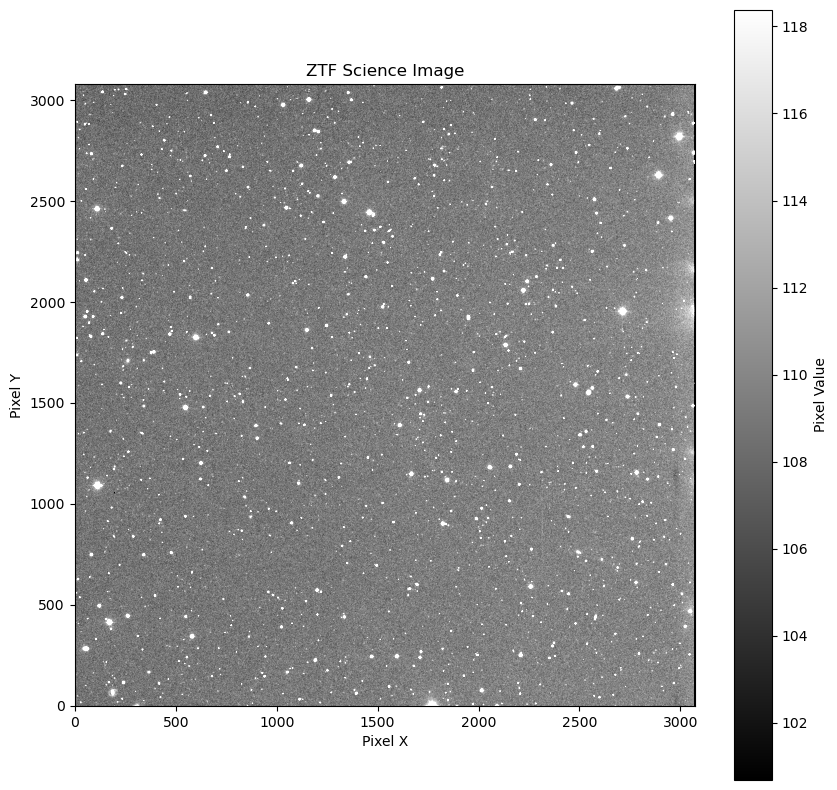

In [7]:
import matplotlib.pyplot as plt
from astropy.io import fits

# Path to the uploaded FITS file
fits_file_path = '/home/jovyan/research/ZTF_images/2021/0220/436771/ztf_20210220436771_000712_zg_c02_o_q3_sciimg.fits'

# Open the FITS file
with fits.open(fits_file_path) as hdul:
    # Print the structure of the FITS file
    hdul.info()
    
    # Access the primary data
    data = hdul[0].data  # Image data from the primary HDU

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(data, cmap='gray', origin='lower', vmin=np.percentile(data, 5), vmax=np.percentile(data, 95))
plt.colorbar(label='Pixel Value')
plt.title('ZTF Science Image')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()


In [11]:
def obs_image (file_path):
    """
    Parse the FITS file name to extract and print the year, month/day, and fractional day as time in 12-hour format with AM/PM.

    Parameters:
    file_path (str): Full path to the FITS file.
    """
    # Extract the file name from the file path
    file_name = file_path.split('/')[-1]
    
    # Split the file name into components using underscores
    parts = file_name.split('_')
    
    # Check if the file name has the expected number of parts
    if len(parts) < 5:
        print(f"File name does not have enough parts to extract the desired information: {file_name}")
        return
    
    # Extract year, month/day, and fracday
    year = parts[1][:4]  # First 4 digits of the 4th part
    month_day = parts[1][4:8]  # Next 4 digits
    fracday = float(f"0.{parts[1][8:]}")  # Remaining part of the 4th part as a fractional number
    
    # Convert fractional day to time
    total_seconds = fracday * 86400  # Convert fractional day to total seconds in the day
    hours = int(total_seconds // 3600)  # Get hours
    minutes = int((total_seconds % 3600) // 60)  # Get minutes
    seconds = int(total_seconds % 60)  # Get seconds
    
    # Determine AM/PM
    am_pm = "AM" if hours < 12 else "PM"
    hours_12 = hours if 1 <= hours <= 12 else hours - 12
    if hours_12 == 0:
        hours_12 = 12  # Convert 0 to 12 for 12-hour format

    # Format time as HH:MM:SS AM/PM
    frac_time = f"{hours_12:02d}:{minutes:02d}:{seconds:02d} {am_pm}"
    
    # Print the extracted information
    print(f"File Name: {file_name}")
    print(f"Year: {year}")
    print(f"Month|Day: {month_day}")
    print(f"Fractional Time: {frac_time}")


# Example usage
fits_file_path = '/home/jovyan/research/ZTF_images/2021/0220/436771/ztf_20210220436771_000712_zg_c02_o_q3_sciimg.fits'
obs_image(fits_file_path)


File Name: ztf_20210220436771_000712_zg_c02_o_q3_sciimg.fits
Year: 2021
Month|Day: 0220
Fractional Time: 10:28:57 AM


Filename: /home/jovyan/research/ZTF_images/2021/0220/436771/ztf_20210220436771_000712_zg_c02_o_q3_sciimg.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  3             1 PrimaryHDU     270   (3072, 3080)   float32   


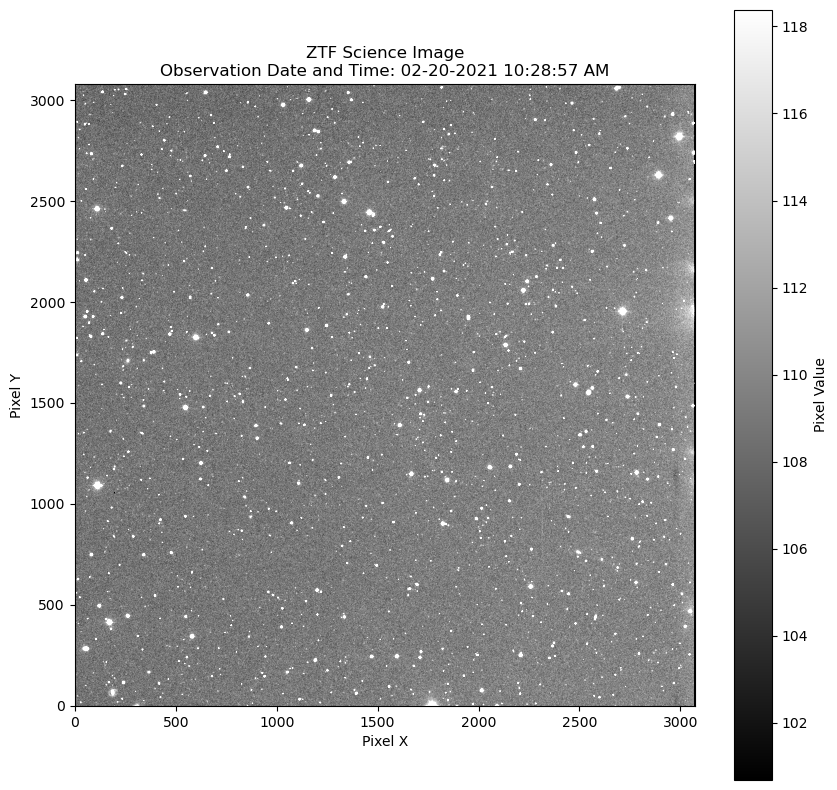

In [14]:
import matplotlib.pyplot as plt
from astropy.io import fits

def obs_image(file_path):
    """
    Parse the FITS file name to extract the month, day, year, and fractional day as time in 12-hour format with AM/PM. 
    Prn

    Parameters:
    file_path (str): Full path to the FITS file.

    Returns:
    str: Formatted string with the month-day-year and time in HH:MM:SS AM/PM format.
    """
    # Extract the file name from the file path
    file_name = file_path.split('/')[-1]
    
    # Split the file name into components using underscores
    parts = file_name.split('_')
    
    # Check if the file name has the expected number of parts
    if len(parts) < 5:
        return "Unknown Date and Time"
    
    # Extract year, month, day, and fracday
    year = parts[1][:4]  # First 4 digits of the 4th part
    month = parts[1][4:6]  # First 2 digits of month/day
    day = parts[1][6:8]  # Last 2 digits of month/day
    fracday = float(f"0.{parts[1][8:]}")  # Remaining part of the 4th part as a fractional number
    
    # Convert fractional day to time
    total_seconds = fracday * 86400  # Convert fractional day to total seconds in the day
    hours = int(total_seconds // 3600)  # Get hours
    minutes = int((total_seconds % 3600) // 60)  # Get minutes
    seconds = int(total_seconds % 60)  # Get seconds
    
    # Determine AM/PM
    am_pm = "AM" if hours < 12 else "PM"
    hours_12 = hours if 1 <= hours <= 12 else hours - 12
    if hours_12 == 0:
        hours_12 = 12  # Convert 0 to 12 for 12-hour format

    # Format time as HH:MM:SS AM/PM
    frac_time = f"{hours_12:02d}:{minutes:02d}:{seconds:02d} {am_pm}"
    
    # Return formatted date and time string (month-day-year format)
    return f"{month}-{day}-{year} {frac_time}"

# Path to the uploaded FITS file
fits_file_path = '/home/jovyan/research/ZTF_images/2021/0220/436771/ztf_20210220436771_000712_zg_c02_o_q3_sciimg.fits'

# Extract the date and time
image_date_time = obs_image(fits_file_path)

# Open the FITS file
with fits.open(fits_file_path) as hdul:
    # Print the structure of the FITS file
    hdul.info()
    
    # Access the primary data
    data = hdul[0].data  # Image data from the primary HDU

# Display the image with date and time in the title
plt.figure(figsize=(10, 10))
plt.imshow(data, cmap='gray', origin='lower', vmin=np.percentile(data, 5), vmax=np.percentile(data, 95))
plt.colorbar(label='Pixel Value')
plt.title(f'ZTF Science Image\nObservation Date and Time: {image_date_time}')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()


In [1]:
#brightness of each sn of fucntion of time
#PANN Stars, we need to find the light in different bands from the galaxy, correc the red shift and put 

In [1]:
#try to get mgnitudes from thr light curve that lASAIR have 

In [ ]:
#I need to get each detection with the cuts that were made of ONE SN

In [ ]:
#pick a gazly, magnitude of a host galazy after that use PRSPECTOR and can figure out the abs mag of host galaxy $$$ I
#IN ALL BANDS, GRIZZY all bands 